# PCA - Fashion MNIST

En éste ejercicio vamos a aplicar PCA y K-means al dataset de Fashion MNIST, que incluye imágenes de prendas de ropa típicas de 28x28. La idea es intentar recopilar información sobre la distribución de las imágenes, usando visualizaciones que permitan clarificar cómo interpretar los resultados obtenidos por PCA.

### Importamos librerías

**Nota**: Al instalar tensorflow en Windows es posible que tire un error y sea necesario tener habilitado `Long Paths`

Abrir PowerShell como administrador y ejecutar:

```powershell
New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" `
-Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force
```

In [1]:
%pip install numpy seaborn pandas sklearn tensorflow

  Using cached sklearn-0.0.post4.tar.gz (3.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\sesteva\AppData\Local\Temp\pip-install-wqzym5i2\sklearn_12f174c9839f4a23ac5e98df4b62af1b\setup.py", line 10, in <module>
          LONG_DESCRIPTION = f.read()
        File "C:\Users\sesteva\AppData\Local\Programs\Python\Python310\lib\encodings\cp1252.py", line 23, in decode
          return codecs.charmap_decode(input,self.errors,decoding_table)[0]
      UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 7: character maps to <undefined>
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

n

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [3]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os
import gzip
import sys
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize 

In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Importamos el dataset

In [5]:
import tensorflow as tf

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


x_train = x_train.reshape((60000, 28*28))
x_test = x_test.reshape((10000, 28*28))

4422102/4422102 [==============================] - 1s 0us/step


In [7]:
print('Formato de las etiquetas: {}'.format(y_train.shape))

Formato de las etiquetas: (60000,)


|     Label     |   Descripción | 
| ------------- |:-------------:|
|       0       | T-shirt/top   |
|       1       | Trouser       |
|       2       | Pullover      |
|       3       | Dress         |
|       4       | Coat          |
|       5       | Sandal        |
|       6       | Shirt         |
|       7       | Sneaker       |
|       8       | Bag           |
|       9       | Ankle boot    |

In [8]:
y_mapping = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [9]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

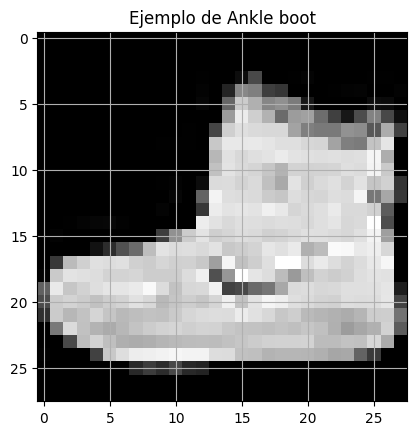

In [10]:
# Cargamos una muestra
plt.grid(True)
plt.title("Ejemplo de {}".format(y_mapping[y_train[0]]))
plt.imshow(x_train[0, :].reshape((28, 28)), cmap='gray')

### Creamos una Clase PCA

In [11]:
class PCA_FMNIST:
    def __init__(self, X, y, n_components, whiten = False):
        '''
        inputs: 
            X                    - dataset de entrada
            y                    - labels
            n_components         - cantidad de componentes principales a usar
            whiten               - indica si se multiplica los elementos por
                                   la raiz cuadrada de X.shape[0] y se divide por los valores singulares --> varianza unitaria
        '''
        self.X = X
        self.n_components = n_components
        self.with_whiten = whiten
        self.y = y
        self.y_mapping = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
                          'Sneaker', 'Bag', 'Ankle boot']
        
        # Normalizamos el dataset
        #self.scaler = StandardScaler()
        # Ver diferencias entre StandardScaler y Normalize
        #self.X_norm = self.scaler.fit_transform(X)
        self.X_norm = normalize(X)
        
        # Aplicamos PCA al dataset normalizado
        self.PCAModel = PCA(n_components=self.n_components, whiten=self.with_whiten)
        self.X_norm_r = self.PCAModel.fit_transform(self.X_norm)
        
    def PCA_transform(self, X):
        return self.PCAModel.transform(X)

    def PCA_reconstruct(self, X_transformed):
        return self.PCAModel.inverse_transform(X_transformed) 
    
    def InterpretUsingModel(self, X):
        return self.PCAModel.inverse_transform(self.PCAModel.transform(X))
    
    def variance_plot(self, n_components):
        plt.subplot(1, 1, 1)
        plt.plot(range(n_components), self.PCAModel.explained_variance_ratio_[:n_components])
        plt.plot(range(n_components), np.cumsum(self.PCAModel.explained_variance_ratio_[:n_components]))
        plt.title("Varianza explicada por componente y Cumulativa ", fontsize=10)

    def last_n_components(self, n_components):
        X_norm = self.X_norm.T
        S = X_norm @ X_norm.T
        eigvals, eigvecs = np.linalg.eig(S) 
        order = np.argsort(eigvals) 
        B = eigvecs[:, order[:n_components]]
        C = B.T @ X_norm 
        X_rec = B @ C 
        X_rec = X_rec.T 
        return X_rec
    
    @staticmethod
    def plot_image(x):
        plt.imshow(x.reshape((28, 28)), cmap='gray')
    
    def plot_example(self, idx):
        plt.grid(True)
        plt.title("Ejemplo de {}".format(y_mapping[self.y[idx]]))
        self.plot_image(self.X[idx, :])
    
    @staticmethod
    def MSE(X, vector):
        n = X.shape[1]
        return np.sum((X - vector) ** 2, axis=1) / n
    
    def plot_reconstructions(self, X, numReconstructions=5):
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        numReconstructionsPerFigure = min(5, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
                
        for figureidx in range(numFigures):
            plt.figure(figsize = (18, 18))
            for plotCol in range(numReconstructionsPerFigure):
                data_idx = np.random.randint(numSamples)
                originalImage = X[data_idx,:].ravel()
                reconstructedImage = self.InterpretUsingModel(np.reshape(X[data_idx,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(originalImage)
                plt.title('Imagen original') 
                plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(reconstructedImage) 
                plt.title('Imagen reconstruida') 
                plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                self.plot_image(diffImage) 
                plt.title('Diferencia absoluta')
                plt.axis('off')
            plt.tight_layout()
    
    def quantile_records(self, X, vector, q=0.5):
        """
        Devuelve el cuantil q del ECM entre la salida original y transformada para un determinado componente.
        """
        errors = self.MSE(X, vector)
        q_value = np.quantile(errors, q, method="lower")
        record = errors==q_value
        return X[record, :]
    
    def plot_quartiles(self, X, trans, n):
        fig, axarr = plt.subplots(n, 7, figsize=(12, n*2))
        for i in range(n):
            vector = trans.components_[i, :]
            sns.heatmap(self.quantile_records(X, vector, q=0.02).reshape(28, 28), cmap='gray_r', ax=axarr[i][0], cbar=False)
            axarr[i][0].set_aspect('equal')
            axarr[i][0].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.1).reshape(28, 28), cmap='gray_r', ax=axarr[i][1], cbar=False)
            axarr[i][1].set_aspect('equal')
            axarr[i][1].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.25).reshape(28, 28), cmap='gray_r', ax=axarr[i][2], cbar=False)
            axarr[i][2].set_aspect('equal')
            axarr[i][2].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.5).reshape(28, 28), cmap='gray_r', ax=axarr[i][3], cbar=False)
            axarr[i][3].set_aspect('equal')
            axarr[i][3].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.75).reshape(28, 28), cmap='gray_r', ax=axarr[i][4], cbar=False)
            axarr[i][4].set_aspect('equal')
            axarr[i][4].axis('off')

            sns.heatmap(self.quantile_records(X, vector, q=0.9).reshape(28, 28), cmap='gray_r', ax=axarr[i][5], cbar=False)
            axarr[i][5].set_aspect('equal')
            axarr[i][5].axis('off')        

            sns.heatmap(self.quantile_records(X, vector, q=0.98).reshape(28, 28), cmap='gray_r', ax=axarr[i][6], cbar=False)        
            axarr[i][6].set_aspect('equal')
            axarr[i][6].axis('off')

        axarr[0][0].set_title('2nd Percentile', fontsize=12)
        axarr[0][1].set_title('10th Percentile', fontsize=12)
        axarr[0][2].set_title('25th Percentile', fontsize=12)
        axarr[0][3].set_title('50th Percentile', fontsize=12)
        axarr[0][4].set_title('75th Percentile', fontsize=12)
        axarr[0][5].set_title('90th Percentile', fontsize=12)
        axarr[0][6].set_title('98th Percentile', fontsize=12)
    
    def plot_pca_space(self):
        plt.figure(figsize=(12,10))
        plt.scatter(self.X_norm_r[:, 0], self.X_norm_r[:, 1], c=self.y, 
        edgecolor='none', alpha=0.7, s=40,
        cmap=plt.cm.get_cmap('nipy_spectral', 10))
        plt.colorbar()
        plt.title('FMNIST - PCA projection 2D');
    
    def ShowVarianceDirections(self, numDirectionsToShow=16):        
        numFigRows = 4 
        numFigCols = 4
        numDirectionsPerFigure = numFigRows*numFigCols
        numFigures = int(np.ceil(float(numDirectionsToShow)/numDirectionsPerFigure))
        for figureInd in range(numFigures):
            plt.figure(figsize=(12,10))
            for plotInd in range(numDirectionsPerFigure):
                eigVecInd = numDirectionsPerFigure*figureInd + plotInd
                deltaImage = self.PCAModel.components_[eigVecInd,:].ravel().reshape((28, 28))
                plt.subplot(numFigRows,numFigCols,plotInd+1)
                plt.imshow(deltaImage,cmap='jet')
                plt.axis('off')
                titleStr = str(100*self.PCAModel.explained_variance_ratio_[eigVecInd])[0:5]
                plt.title(titleStr + '% explained')
            plt.tight_layout()
            
    def ShowModelVariations(self, numVariations=5):
                
        numVarsPerFigure = min(5,numVariations)
        numFigures = int(np.ceil(float(numVariations)/numVarsPerFigure))
        
        lowRepVec     = np.percentile(self.X_norm_r, 2, axis=0)
        medianRepVec  = np.percentile(self.X_norm_r, 50, axis=0)
        highRepVec    = np.percentile(self.X_norm_r, 98, axis=0)

        for figureInd in range(numFigures):
            plt.figure(figsize=(18,18))
            for plotCol in range(numVarsPerFigure):
                eigVecInd = numVarsPerFigure*figureInd+plotCol

                # Representación de los vectores de activación por percentil
                currLowPrecentileRepVec             = medianRepVec.copy()
                currLowPrecentileRepVec[eigVecInd]  = lowRepVec[eigVecInd]
                currHighPrecentileRepVec            = medianRepVec.copy()
                currHighPrecentileRepVec[eigVecInd] = highRepVec[eigVecInd]
                
                deltaImage = self.PCAModel.components_[eigVecInd,:].ravel().reshape((28, 28))
                lowPrecentileImage = self.PCAModel.inverse_transform(currLowPrecentileRepVec).ravel().reshape((28, 28))
                medianImage = self.PCAModel.inverse_transform(medianRepVec).ravel().reshape((28, 28))
                highPrecentileImage = self.PCAModel.inverse_transform(currHighPrecentileRepVec).ravel().reshape((28, 28))
                
                # Calculamos con KDE la distribución Gaussiana de los valores en la dirección de un componente
                # Valor arbitrario
                sigmaOfKDE = 0.12
                pdfStart   = min(self.X_norm_r[:,eigVecInd]) - 3*sigmaOfKDE
                pdfStop    = max(self.X_norm_r[:,eigVecInd]) + 3*sigmaOfKDE
                xAxis = np.linspace(pdfStart,pdfStop,200)
                PDF_Model = KernelDensity(kernel='gaussian', 
                                  bandwidth=sigmaOfKDE).fit(self.X_norm_r[:,eigVecInd].reshape(-1,1))
                logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))

                # show distribution of current component 
                plt.subplot(5,numVarsPerFigure,0*numVarsPerFigure+plotCol+1)
                plt.fill(xAxis, np.exp(logPDF), fc='b')
                percentExplainedString = str(100*self.PCAModel.explained_variance_ratio_[eigVecInd])[0:5]
                plt.title(percentExplainedString + '% explained') 
                
                # show variance direction (eigenvector)
                plt.subplot(5,numVarsPerFigure,1*numVarsPerFigure+plotCol+1)
                plt.imshow(deltaImage, cmap='jet') 
                plt.title('eigenvector ' + str(eigVecInd)) 
                plt.axis('off')

                # show 2nd precentile image
                plt.subplot(5,numVarsPerFigure,2*numVarsPerFigure+plotCol+1)
                plt.imshow(lowPrecentileImage, cmap='gray')
                plt.title('2nd precentile image') 
                plt.axis('off')

                # show median image
                plt.subplot(5,numVarsPerFigure,3*numVarsPerFigure+plotCol+1)
                plt.imshow(medianImage, cmap='gray') 
                plt.title('median Image') 
                plt.axis('off')

                # show 98th precentile image
                plt.subplot(5,numVarsPerFigure,4*numVarsPerFigure+plotCol+1)
                plt.imshow(highPrecentileImage, cmap='gray') 
                plt.title('98th precentile image')
                plt.axis('off')
            plt.tight_layout()
            
    def ShowSingleComponentVariation(self, listOfComponents=[0,1]):
        percentilesToShow = [1,20,40,60,80,99]
        numReadDataSamplePerPercentile = 1
        representationPercentiles = []
        
        # Percentiles de los datos transformados
        # TODO: usar la función quartile creada más arriba
        for percentile in percentilesToShow:
            representationPercentiles.append(np.percentile(self.X_norm_r, percentile, axis=0))
        
        medianRepVec =  np.percentile(self.X_norm_r, 50, axis=0)

        for eigVecInd in listOfComponents:
            plt.figure(figsize=(18,18)) 
            gs = gridspec.GridSpec(numReadDataSamplePerPercentile+2, len(percentilesToShow))

            # Calculamos con KDE la distribución Gaussiana de los valores en la dirección de un componente
            sigmaOfKDE = 0.12
            pdfStart   = min(self.X_norm_r[:,eigVecInd]) - 3*sigmaOfKDE
            pdfStop    = max(self.X_norm_r[:,eigVecInd]) + 3*sigmaOfKDE
            xAxis = np.linspace(pdfStart,pdfStop,200)
            PDF_Model = KernelDensity(kernel='gaussian', 
                              bandwidth=sigmaOfKDE).fit(self.X_norm_r[:,eigVecInd].reshape(-1,1))
            logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
            
            percentileValuesToShow = \
                    [representationPercentiles[x][eigVecInd] for x in range(len(representationPercentiles))]
            percentilesToShowLogPDF = \
                    PDF_Model.score_samples(np.array(percentileValuesToShow).reshape(-1,1))
            

            # Plotear la distribución y puntos rojos en los percentiles
            plt.subplot(gs[0,:])
            plt.fill(xAxis, np.exp(logPDF), fc='b');
            plt.scatter(percentileValuesToShow, np.exp(percentilesToShowLogPDF), c='r',s=40);
            plt.title(str(100*self.PCAModel.explained_variance_ratio_[eigVecInd]) + '% explained');
            
            for plotCol, currPrecentile in enumerate(percentilesToShow):                
                currPrecentileRepVec             = medianRepVec.copy()
                currPrecentileRepVec[eigVecInd]  = representationPercentiles[plotCol][eigVecInd]                
                currPrecentileImage = self.PCAModel.inverse_transform(currPrecentileRepVec).ravel().reshape((28, 28))
                
                # Mostrar la imagen "mediana"
                plt.subplot(gs[1,plotCol]);
                plt.imshow(currPrecentileImage, cmap='gray'); 
                plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); 
                plt.axis('off')
                
            plt.tight_layout()

### Exploramos los resultados de PCA

In [12]:
x_train.shape, y_train.shape

((60000, 784), (60000,))

In [13]:
# Instanciamos la clase
PCA_FM = PCA_FMNIST(x_train, y_train, 120)

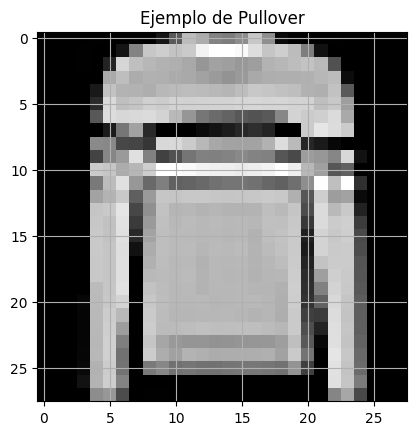

In [14]:
# Ploteamos un ejemplo de los datos
PCA_FM.plot_example(5)

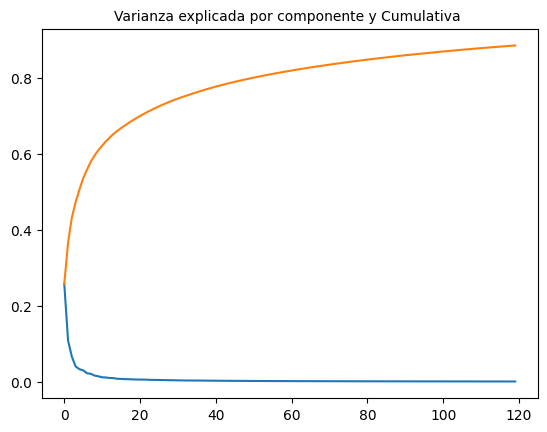

In [15]:
# Ploteamos el ratio de explicabilidad de la varianza en función de la cantidad de componentes principales
PCA_FM.variance_plot(n_components=120)

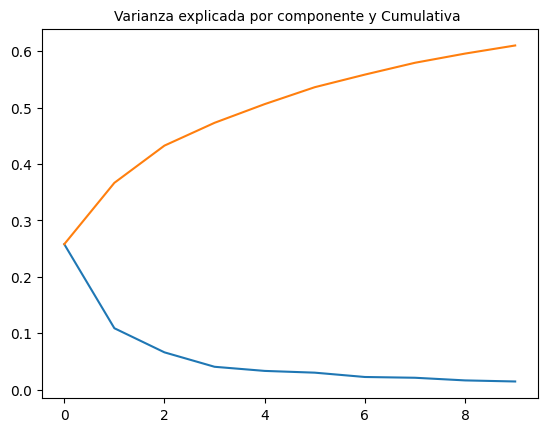

In [16]:
PCA_FM.variance_plot(n_components=10)

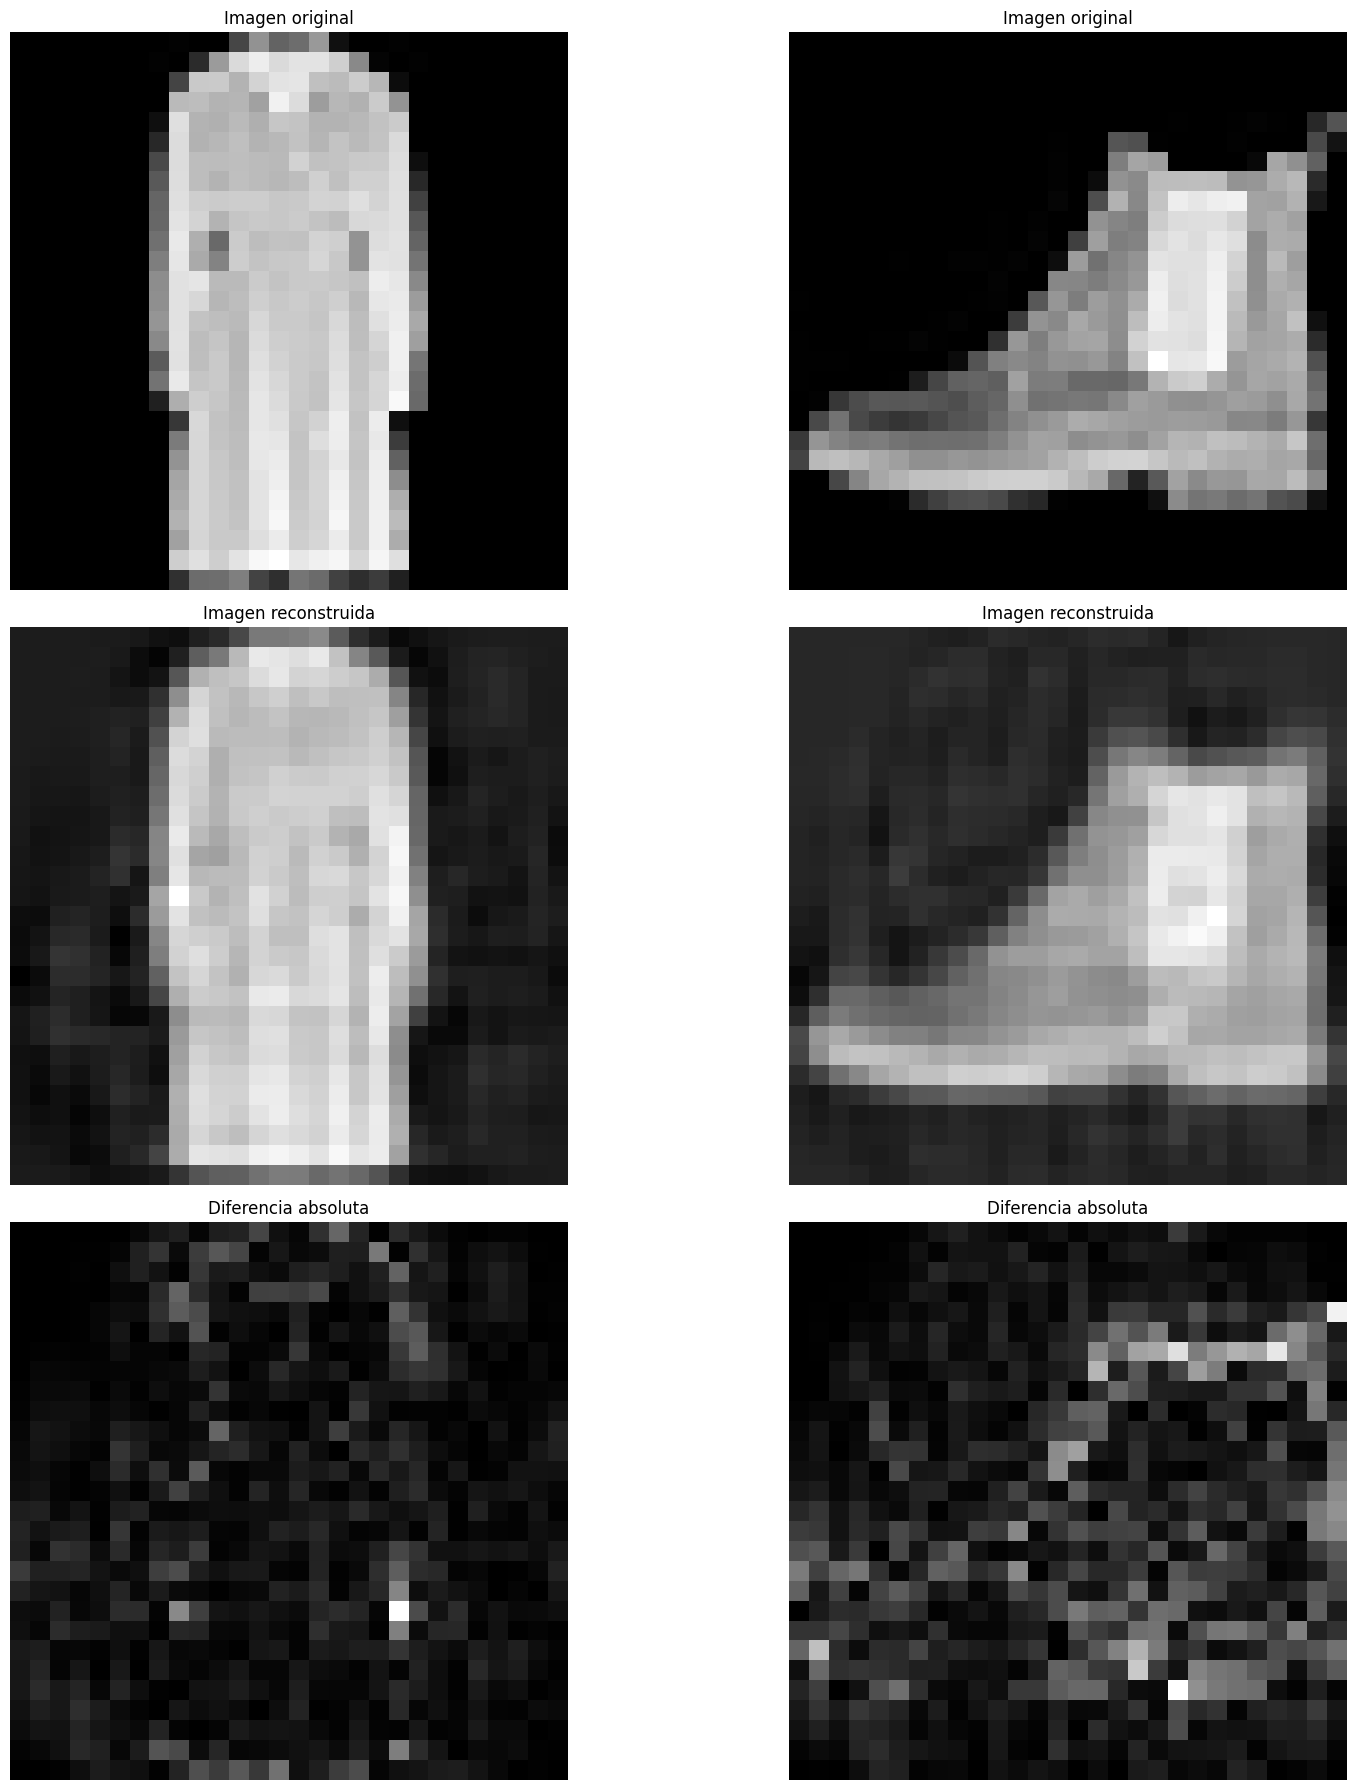

In [17]:
# Mostramos algunas reconstrucciones
PCA_FM.plot_reconstructions(x_train, 2)

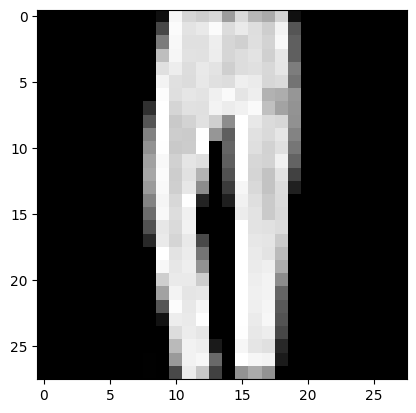

In [18]:
# Plotear un cuartil determinado para un compontente determinado

PCA_FM.plot_image(PCA_FM.quantile_records(PCA_FM.X_norm, PCA_FM.PCAModel.components_[0,:], 0.98))

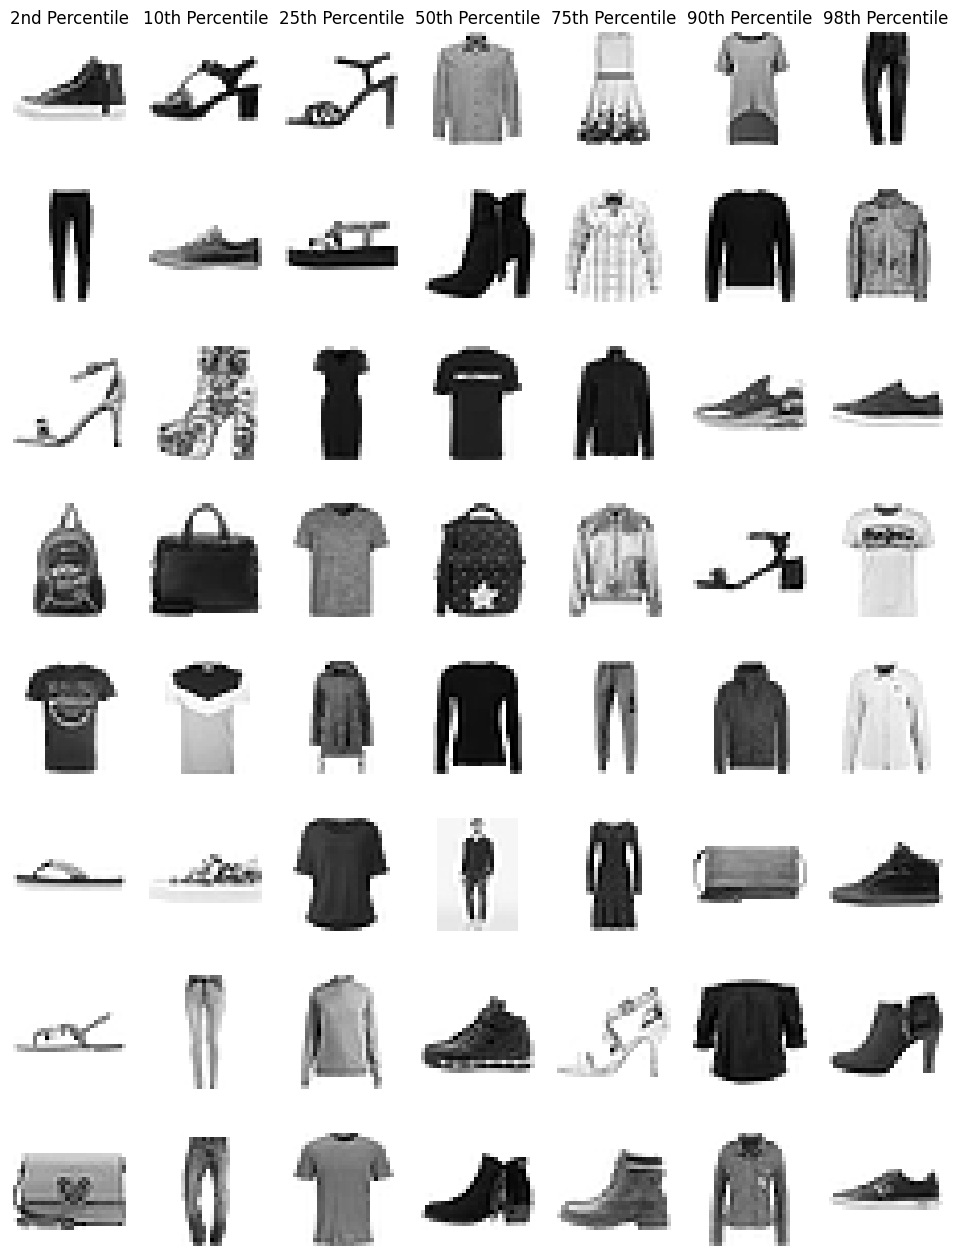

In [19]:
# Plotear cuartiles de 8 componentes
PCA_FM.plot_quartiles(PCA_FM.X_norm, PCA_FM.PCAModel, 8)

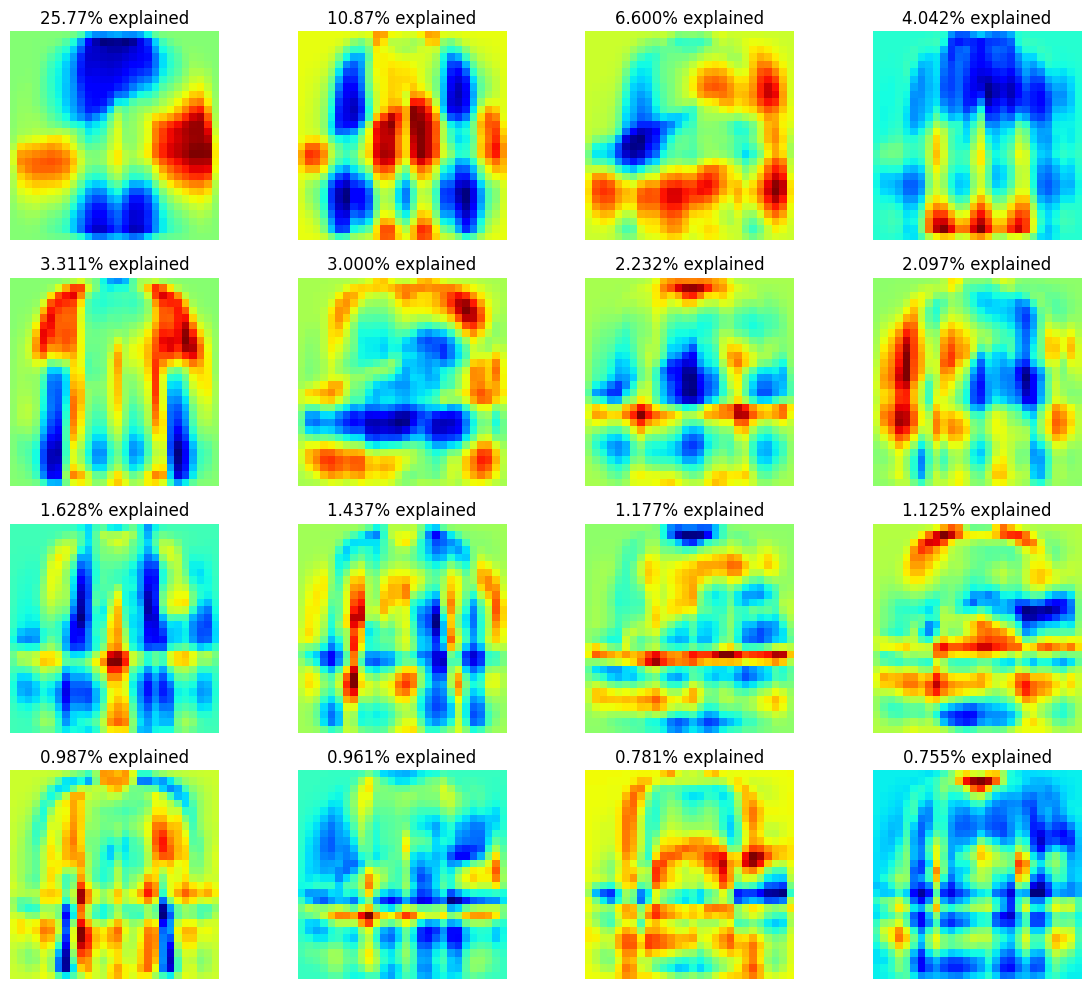

In [20]:
# Mostramos las direcciones principales de varianza
PCA_FM.ShowVarianceDirections(16)

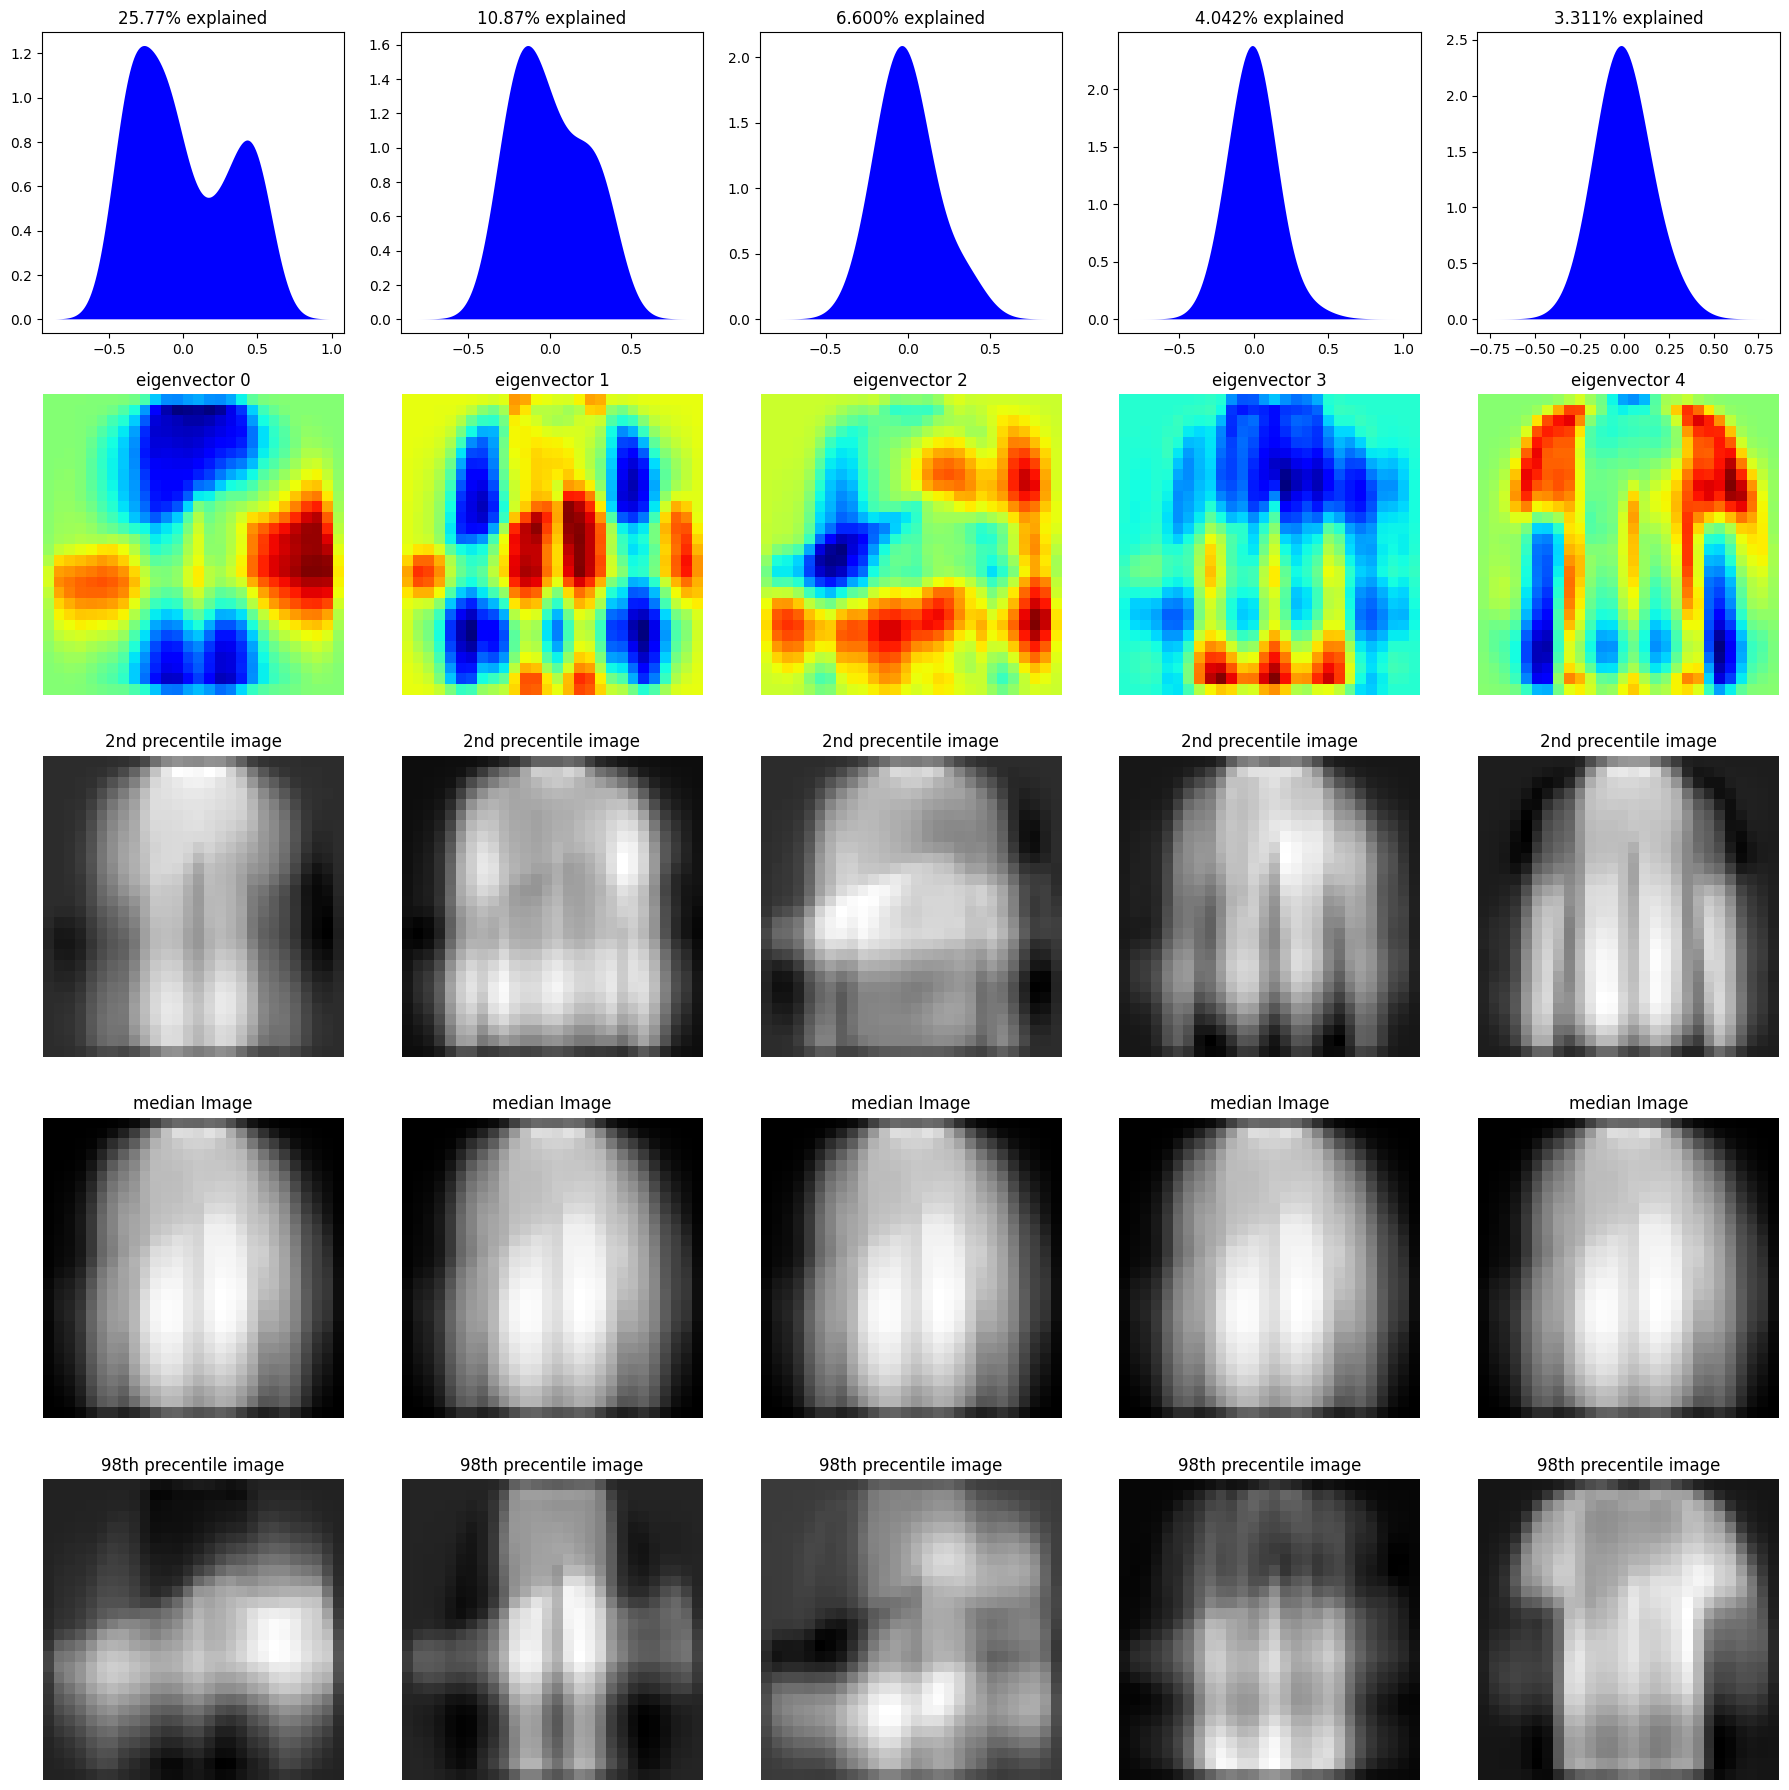

In [21]:
# En el siguiente gráfico vamos a mostrar los histogramas correspondientes a la distribución de cada una de las direcciones de 
# mayor varianza (autovectores). Mostrar para cada componente, la mediana y algunos percentiles. Se vuelven a mostrar las
# direcciones de varianza

PCA_FM.ShowModelVariations()

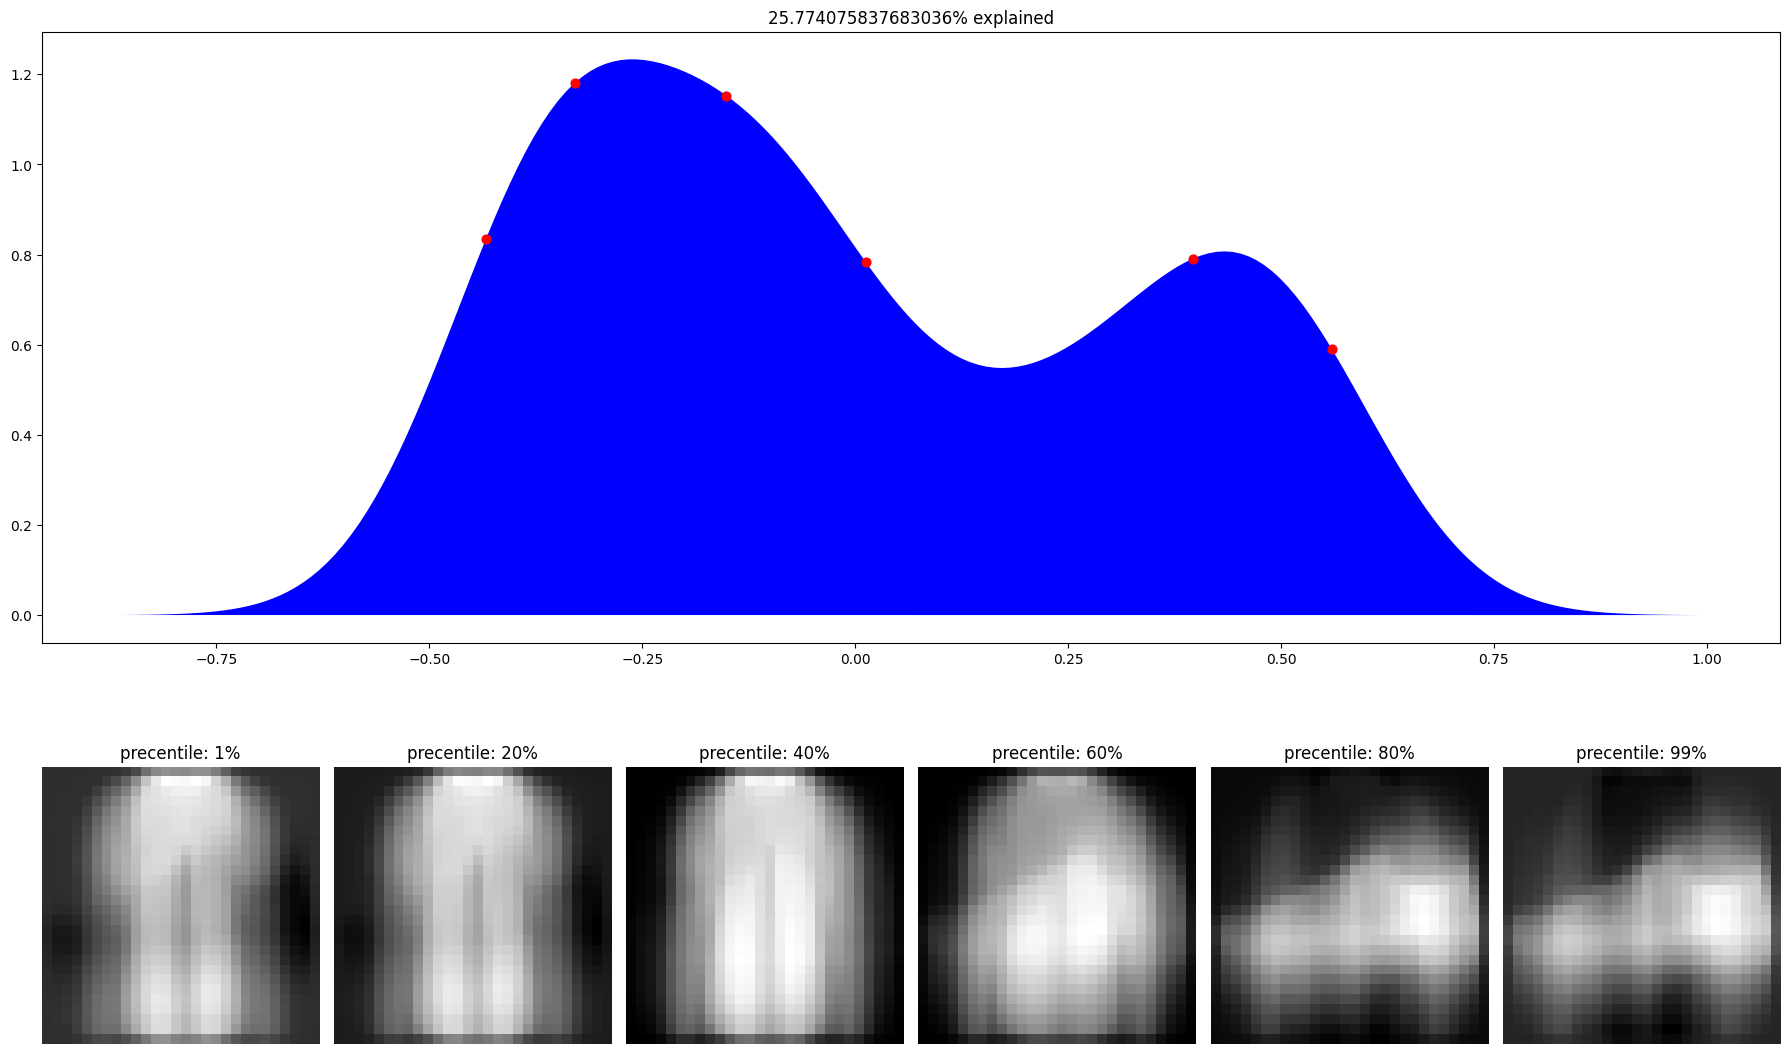

In [22]:
PCA_FM.ShowSingleComponentVariation(listOfComponents=[0])

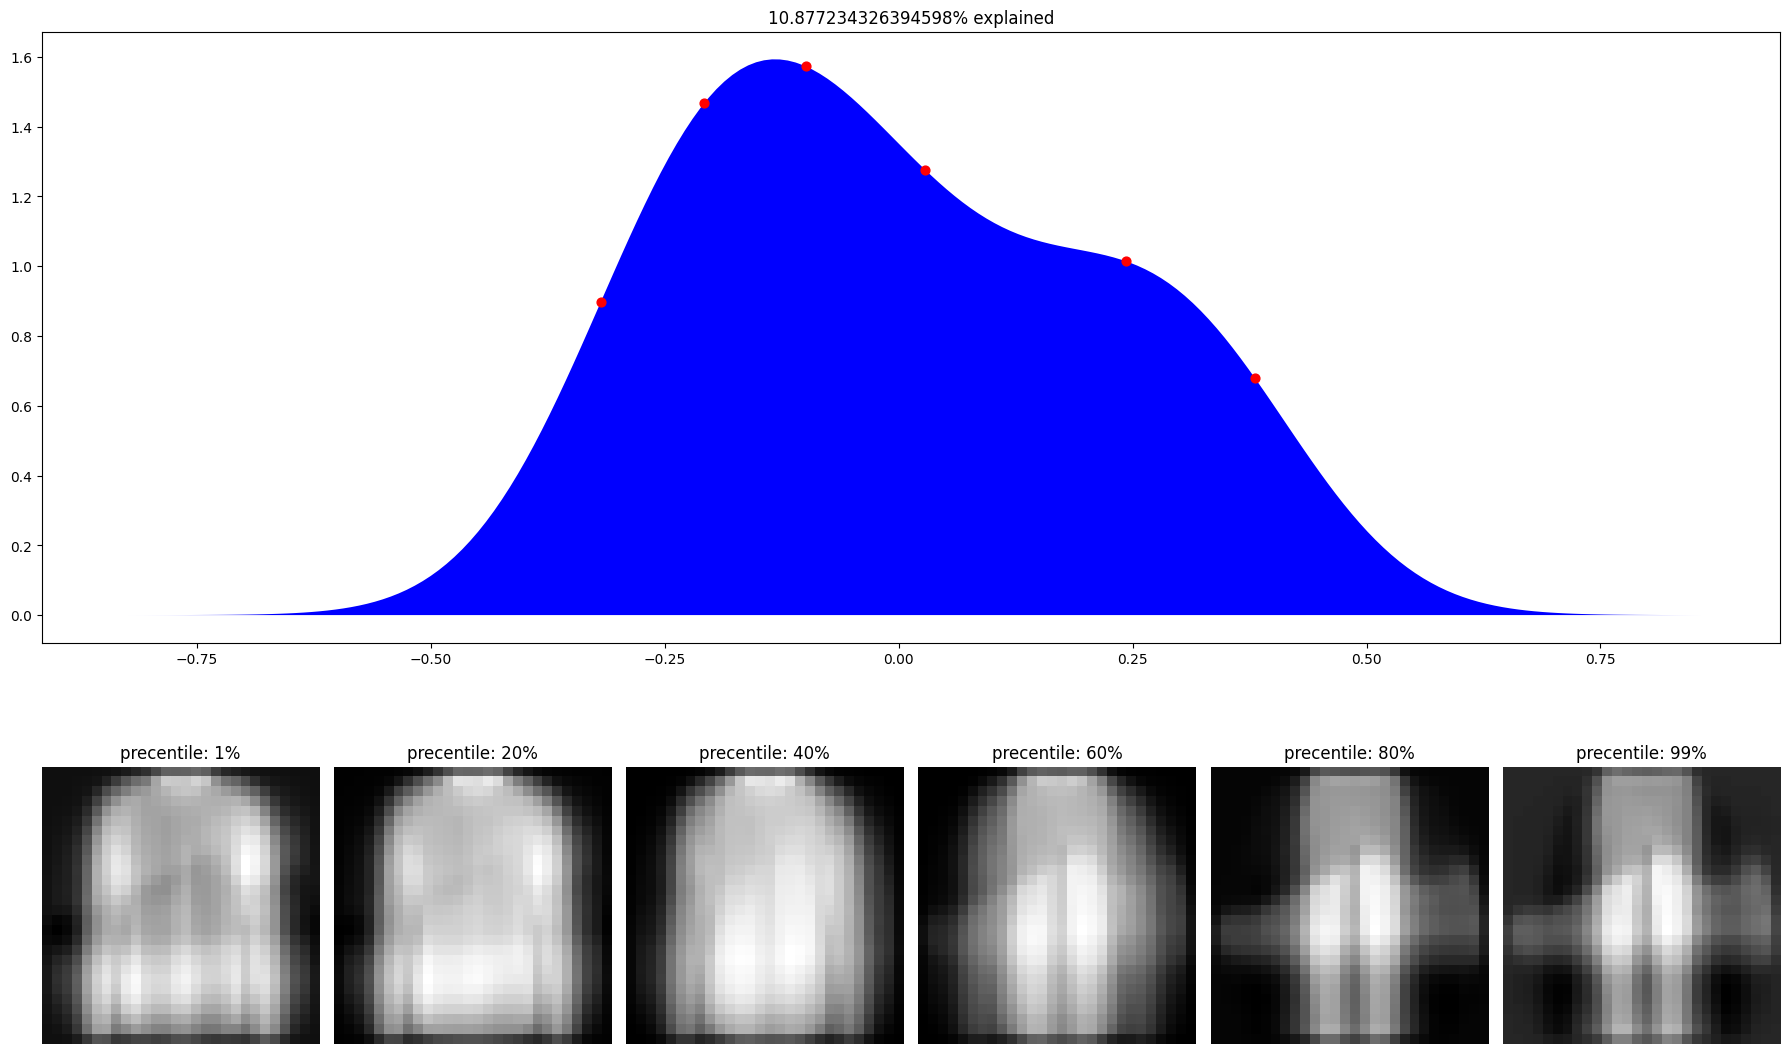

In [23]:
PCA_FM.ShowSingleComponentVariation(listOfComponents=[1])

In [24]:
y_mapping

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

C:\Users\sesteva\AppData\Local\Temp\ipykernel_9520\2304699415.py:154: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


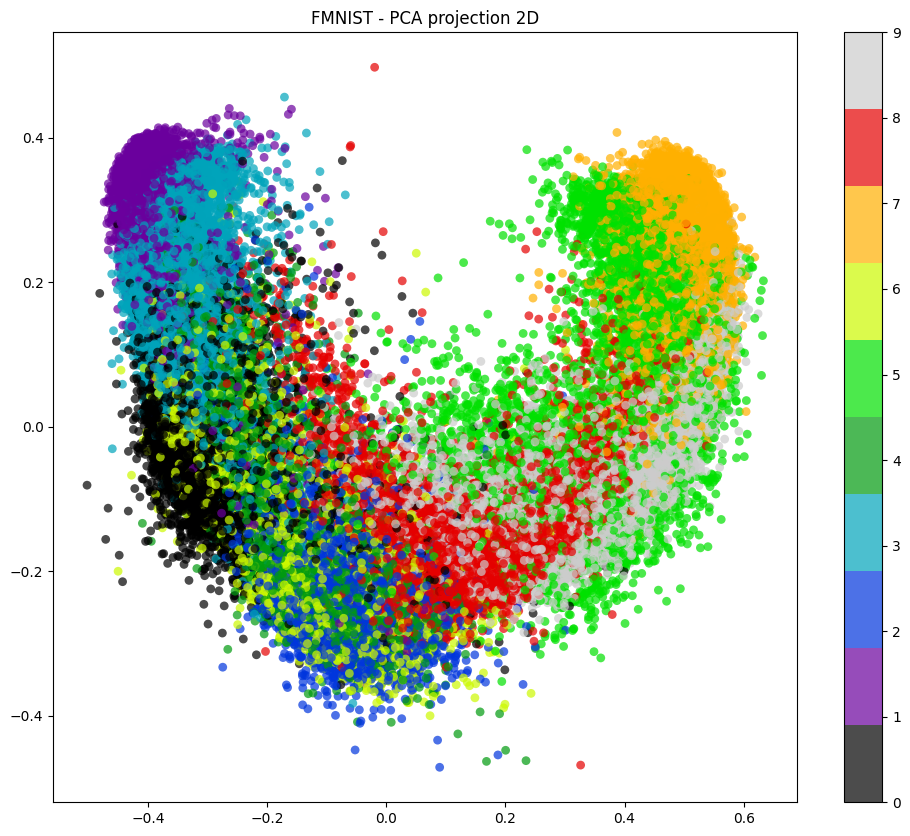

In [25]:
PCA_FM.plot_pca_space()

---

### Bibliografía

[Zalando SE Research [2017]. Fashion MNIST dataset.](https://github.com/zalandoresearch/fashion-mnist)

[Understanding your data Principal Component Analysis](https://medium.com/deepdreaming/understanding-your-data-principal-component-analysis-86111bc9df37#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6Ijc3MjA5MTA0Y2NkODkwYTVhZWRkNjczM2UwMjUyZjU0ZTg4MmYxM2MiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MjAwODgzMjMsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExMjUzOTE2NDM2NDY2NDIyNTUzMyIsImVtYWlsIjoibGRjMDI5NUBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiYXpwIjoiMjE2Mjk2MDM1ODM0LWsxazZxZTA2MHMydHAyYTJqYW00bGpkY21zMDBzdHRnLmFwcHMuZ29vZ2xldXNlcmNvbnRlbnQuY29tIiwibmFtZSI6IkxhdXRhcm8gRGVsZ2FkbyIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS0vQU9oMTRHaURFQXFod3J6dEltUzYyZUw5TGR4MXBwMlhaWk9YWlM3Q3YzUHlndz1zOTYtYyIsImdpdmVuX25hbWUiOiJMYXV0YXJvIiwiZmFtaWx5X25hbWUiOiJEZWxnYWRvIiwiaWF0IjoxNjIwMDg4NjIzLCJleHAiOjE2MjAwOTIyMjMsImp0aSI6ImU3Mjc5ZDMyMDYzMmJiMWZkZWRjMjEzYzBlMTAwMzlkMTA2NmRmYjYifQ.mUwiLvnfIiFjqDfMl2lhuwNT_VD4BQTr2SlFcfJOrVEWllerdpxNd7sjPwTC4r5Pp-64ZI0rpku772uzF1OAFrmCB1gHwHJCPOCDNifInI9N8w-609xPk9dJEigoaTtZbTjYptddTbf3Rj1lbw_aIuG2sMXYmSAvzxFRTsTx0WsnzE6rtGwlAmOI1LnLCBC4h5A1JJzr2-7l13YgytbSNDKzR5GCDsU0EroG_auDaHK9_WOl6VmbXhQ2dY-I7EzV9FEa8PeO6UmPIOzNZw-dm2pCMoOGnEr1j0r0ZKeBVvyVV59pyHDOFN0qt7lrnxBJZIdV743dUZoQUB-EVygrcw)

[Kaggle Notebook 1](https://www.kaggle.com/residentmario/dimensionality-reduction-and-pca-for-fashion-mnist)

[Kaggle Notebook 2](https://www.kaggle.com/selfishgene/visualizing-pca-with-leaf-dataset)

[Kaggle Notebook 3](https://www.kaggle.com/marnixk/image-compression-with-pca-from-scratch-math)